In [0]:
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, Conv2D, MaxPooling2D
from keras.layers import Activation, Flatten, BatchNormalization, GlobalAveragePooling2D, Dropout
from keras.optimizers import Adam, SGD
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.datasets import cifar10
from keras.applications.vgg16 import preprocess_input
from keras import backend as K
import cv2

from google.colab import drive

import time
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline
np.random.seed(2017)

batch_size = 128

drive.mount('/content/gdrive')
dir="/content/gdrive/My Drive/Colab Notebooks/EVA/"
!ls

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
gdrive	sample_data


In [0]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
label_dict = {0:"airplane", 1:"automobile", 2:"bird", 3:"cat", 4:"deer", 5:"dog", 6:"frog", 7:"horse", 8:"ship", 9:"truck"}

# Convert 1-dimensional class arrays to 10-dimensional class matrices
Y_train = np_utils.to_categorical(y_train, 10)
Y_test = np_utils.to_categorical(y_test, 10)
print(Y_train.shape)

170500096/170498071 [==============================] - 9s 0us/step
(50000, 10)


### Applying image augmentation and cutout with mean of the whole dataset

In [0]:
def get_img_mean(img_dataset):
  #print(img_dataset.shape)
  avg = np.mean(img_dataset)
  return avg

def get_random_eraser(p=0.6, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, pixel_val=0):
  def eraser(input_img):
    img_h, img_w, img_c = input_img.shape
    #print(input_img.shape)
    p_1 = np.random.rand()

    if p_1 > p:
      return input_img

    while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break
    #c = np.random.uniform(v_l, v_h)

    input_img[top:top + h, left:left + w, :] = pixel_val
    # print("Pixel",pixel_val)      
    # print("Patch size", h, w)
      
    return input_img
  return eraser

In [0]:
val = get_img_mean(X_train)
print(val)
cutout = get_random_eraser(pixel_val=val)

train_datagen = ImageDataGenerator(zoom_range = 0.2,
                                   brightness_range=[0.8, 1.2],
                                   width_shift_range=0.15, 
                                   height_shift_range=0.15, 
                                   rotation_range=20, 
                                   horizontal_flip=True,
                                   preprocessing_function=cutout)
test_datagen = ImageDataGenerator()

train_gen = train_datagen.flow(X_train, Y_train, batch_size=batch_size, shuffle=True, seed=42)
test_gen = test_datagen.flow(X_test, Y_test, batch_size=batch_size, shuffle=True, seed=42)

train_steps = len(train_gen)
test_steps = len(test_gen)
print("Steps :",train_steps, test_steps)

120.70756512369792
Steps : 391 79


#### Model for running gradCam

In [0]:
def build_model():
  model = Sequential()
  
  model.add(Conv2D(32, 3, padding='same', activation='relu', name='conv_1', input_shape=(32, 32, 3))) #rf 3
  model.add(BatchNormalization())
  model.add(Dropout(0.1))
  model.add(Conv2D(64, 3, padding='same', activation='relu', name='conv_2')) 
  model.add(BatchNormalization())
  model.add(Dropout(0.1))
  model.add(Conv2D(128, 3, padding='same', activation='relu', name='conv_3')) # rf7
  model.add(BatchNormalization()) 
  model.add(Dropout(0.1))
  
  model.add(Conv2D(96, 1, activation='relu', name='conv_4'))
  model.add(MaxPooling2D(pool_size=(2, 2))) #16, rf14 

  model.add(Conv2D(128, 3, padding='same', activation='relu', name='conv_5'))
  model.add(BatchNormalization())
  model.add(Dropout(0.1))
  model.add(Conv2D(256, 3, padding='same', activation='relu', name='conv_6')) #rf18
  model.add(BatchNormalization())
  model.add(Dropout(0.1))
  model.add(Conv2D(512, 3, padding='same', activation='relu', name='conv_7')) #rf20
  model.add(BatchNormalization())
  model.add(Dropout(0.1))
    
  model.add(Conv2D(256, 1, activation='relu', name='conv_8'))
  model.add(MaxPooling2D(pool_size=(2, 2))) #8, rf40
  
  model.add(Conv2D(128, 1, activation='relu', name='conv_9'))
  model.add(Conv2D(10, 8))
    
  model.add(GlobalAveragePooling2D())
  model.add(Activation('softmax'))
  return model

#### Using LR Finder to find the starting learning rate
http://puzzlemusa.com/2018/05/14/learning-rate-finder-using-keras/

In [0]:
class LR_Finder(Callback):
    
    def __init__(self, start_lr=1e-5, end_lr=10, step_size=None, beta=.98):
        super().__init__()
        
        self.start_lr = start_lr
        self.end_lr = end_lr
        self.step_size = step_size
        self.beta = beta
        self.lr_mult = (end_lr/start_lr)**(1/step_size)
        print("self.lr_mult", self.lr_mult)
        
    def on_train_begin(self, logs=None):
        self.best_loss = 1e9
        self.avg_loss = 0
        self.losses, self.smoothed_losses, self.lrs, self.iterations = [], [], [], []
        self.iteration = 0
        logs = logs or {}
        K.set_value(self.model.optimizer.lr, self.start_lr)
        
    def on_batch_end(self, epoch, logs=None):
        logs = logs or {}
        loss = logs.get('loss')
        self.iteration += 1
        #print(" ITERATIONS", self.iteration)
        
        self.avg_loss = self.beta * self.avg_loss + (1 - self.beta) * loss
        smoothed_loss = self.avg_loss / (1 - self.beta**self.iteration)
        #print(smoothed_loss,":", loss)
        
        # Check if the loss is not exploding
        if self.iteration>1 and smoothed_loss > self.best_loss * 4:
            print(" LOSS EXPLODING")
            self.model.stop_training = True
            return

        if smoothed_loss < self.best_loss or self.iteration==1:
            self.best_loss = smoothed_loss
        
        lr = self.start_lr * (self.lr_mult**self.iteration)
        print(" LR", lr)
        
        self.losses.append(loss)
        self.smoothed_losses.append(smoothed_loss)
        self.lrs.append(lr)
        self.iterations.append(self.iteration)        
        
        K.set_value(self.model.optimizer.lr, lr)  
        
    def plot_lr(self):
        plt.xlabel('Iterations')
        plt.ylabel('Learning rate')
        plt.plot(self.iterations, self.lrs)
        
    def plot(self, n_skip=10):
        plt.ylabel('Loss')
        plt.xlabel('Learning rate (log scale)')
        plt.plot(self.lrs[n_skip:-5], self.losses[n_skip:-5])
        plt.xscale('log')
        
    def plot_smoothed_loss(self, n_skip=10):
        plt.ylabel('Smoothed Losses')
        plt.xlabel('Learning rate (log scale)')
        plt.plot(self.lrs[n_skip:-5], self.smoothed_losses[n_skip:-5])
        plt.xscale('log')
        
    def plot_loss(self):
        plt.ylabel('Losses')
        plt.xlabel('Iterations')
        plt.plot(self.iterations[10:], self.losses[10:])
        
    def plot_losses(self, n_skip=10):
        plt.rcParams["figure.figsize"] = (10, 5)
        plt.subplot(1, 2, 1)
        plt.ylabel('Loss')
        plt.xlabel('Learning rate (log scale)')
        plt.plot(self.lrs[n_skip:-5], self.losses[n_skip:-5])
        plt.xscale('log')
        
        plt.subplot(1, 2, 2)         
        plt.ylabel('Smoothed Losses')
        plt.xlabel('Learning rate (log scale)')
        plt.plot(self.lrs[n_skip:-5], self.smoothed_losses[n_skip:-5])
        plt.xscale('log')

In [0]:
cutout_model=build_model()
cutout_model.summary()
cutout_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])







Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 32, 32, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
dropout_2 (Dropout)          (None, 32, 32, 64)        0        

In [0]:
lr_finder = LR_Finder(start_lr=1e-3, end_lr=1e-1, step_size=train_steps)
cutout_model.fit_generator(train_gen, steps_per_epoch=train_steps, epochs=1, 
                    callbacks = [lr_finder]) 

self.lr_mult 1.0118475617772233
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/1
390/391 [============================>.] - ETA: 0s - loss: 2.0535 - acc: 0.2475 LR 0.0988291159434718
 LR 0.10000000000000044
391/391 [==============================] - 50s 127ms/step - loss: 2.0542 - acc: 0.2471


#### Taking starting lr at a point between 1e-2 and 1e-3, ie 3e-3

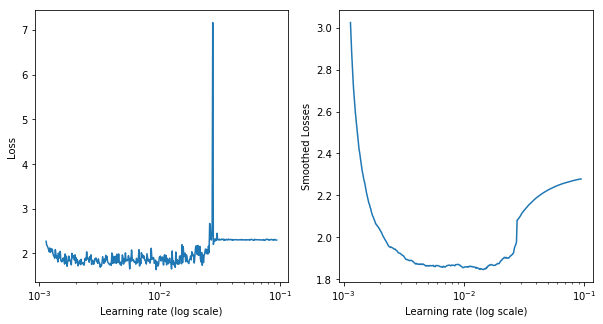

In [0]:
lr_finder.plot_losses()

#### Best validation accuracy in 57 epochs is 86.08% with training acc. 82.64%. Overfitting removed.

In [0]:
cutout_model=build_model()
sgd = SGD(lr=0.003, momentum=0.9)
cutout_model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

file = dir + "Weights/Assign11.{epoch:03d}-{val_acc:.4f}.hdf5"
checkpoint = ModelCheckpoint(file, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
early_stopper = EarlyStopping(min_delta=0.001, patience=10)

model_info = cutout_model.fit_generator(train_gen, steps_per_epoch=train_steps, epochs=80, verbose=1,
                                 validation_data=test_gen, validation_steps=test_steps, callbacks = [checkpoint, early_stopper])

Epoch 1/80
391/391 [==============================] - 49s 124ms/step - loss: 1.7663 - acc: 0.3690 - val_loss: 1.4549 - val_acc: 0.4895

Epoch 00001: val_acc improved from -inf to 0.48950, saving model to /content/gdrive/My Drive/Colab Notebooks/EVA/Weights/Assign11.001-0.4895.hdf5
Epoch 2/80
391/391 [==============================] - 46s 119ms/step - loss: 1.4680 - acc: 0.4713 - val_loss: 1.2681 - val_acc: 0.5472

Epoch 00002: val_acc improved from 0.48950 to 0.54720, saving model to /content/gdrive/My Drive/Colab Notebooks/EVA/Weights/Assign11.002-0.5472.hdf5
Epoch 3/80
391/391 [==============================] - 47s 119ms/step - loss: 1.3318 - acc: 0.5234 - val_loss: 1.2052 - val_acc: 0.5652

Epoch 00003: val_acc improved from 0.54720 to 0.56520, saving model to /content/gdrive/My Drive/Colab Notebooks/EVA/Weights/Assign11.003-0.5652.hdf5
Epoch 4/80
391/391 [==============================] - 46s 119ms/step - loss: 1.2390 - acc: 0.5599 - val_loss: 0.9571 - val_acc: 0.6556

Epoch 00004:

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(10,4))
    # Set axis properties [xmin, xmax, ymin, ymax]
    axs[0].axis([0,50,0.4,1])
    
    # Plot training & validation accuracy values
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    #axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    
    # Plot training & validation loss values
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    #axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()  
    

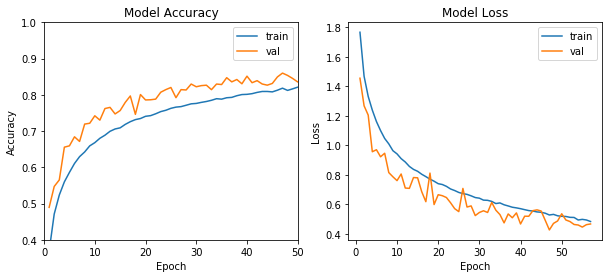

In [0]:
plot_model_history(model_info)

In [0]:
cutout_model=build_model()
sgd = SGD(lr=0.003, momentum=0.9)
cutout_model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

cutout_model.load_weights(dir + "Weights/Assign11.055-0.8608.hdf5")
print("Loaded model from disk ")
cutout_model.evaluate_generator(generator=test_gen, steps=test_steps, verbose=1)

Loaded model from disk 
79/79 [==============================] - 3s 38ms/step


[0.4467549017190933, 0.8608]

In [0]:
def get_activation_heatmap(img_idx, model, layer_name):
  # After expansion, shape : (1, 32, 32, 3)
  x = np.expand_dims(X_test[img_idx], axis=0)
  
  # Normalize our image by subtracting mean RGB values from the input image
  im_proc = preprocess_input(x)
  #print("im_proc", im_proc.shape)
  
  pred_val = model.predict(im_proc)
  pred_class_idx = np.argmax(pred_val)
  #print(img_idx, " Class pred ", pred_class_idx)

  # Compute map for the topmost class, class_output shape=(?,)
  class_output = model.output[:, pred_class_idx]
    
  layer_for_gradcam = model.get_layer(layer_name)
  #print(type(layer_for_gradcam), "layer_for_gradcam", layer_for_gradcam.output.shape)
  
  # Compute the gradient of the class output value with respect to the feature map. 
  grads = K.gradients(class_output, layer_for_gradcam.output)[0]  #(?, 8, 8, 128)

  # Pool the gradients over all the axes leaving out the channel dim  
  # Mean for each channel, like GAP
  pooled_grads = K.mean(grads, axis=(0, 1, 2))  #(128,)
  iterate = K.function([model.input], [pooled_grads, layer_for_gradcam.output[0]])

  # iterate over tensor to get the actual values of 128 pooled_grads
  pooled_grads_value, conv_layer_output_value = iterate([x])  #x - (1, 32, 32, 3)
  
  # Weigh the output feature map of conv_9 with the computed gradient values.
  for i in range(layer_for_gradcam.output.shape[3]): # output channels of the gradcam layer
      conv_layer_output_value[:, :, i] *= pooled_grads_value[i] 
  #print("After for loop", conv_layer_output_value.shape) #(8, 8, 128)
  
  # Average the weighed feature map along the channel dimension resulting in a heat map of size 8x8  
  heatmap = np.mean(conv_layer_output_value, axis=-1)

  # Propagate only the positive values
  heatmap = np.maximum(heatmap, 0)

  # Then normalize the heat map to make the values in between 0 and 1
  heatmap /= np.max(heatmap)
  #print(heatmap[0,:])  
  
  # Resize heatmap from 8x8 to 32x32
  heatmap = cv2.resize(heatmap, (32,32))
  heatmap = np.uint8(255 * heatmap)
  
  # cv2 colormaps create BGR, not RGB
  #heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
  heatmap = cv2.cvtColor(cv2.applyColorMap(heatmap, cv2.COLORMAP_JET), cv2.COLOR_BGR2RGB)
  
  # After this heatmap - 32x32x3  
  return heatmap

In [0]:
def plot_gradCam(model, img_list):
  y_pred = model.predict(X_test)
  pred_classes = np.argmax(y_pred, axis=1)
  
  fig = plt.figure(figsize=(16, 10)) # width,height
  
  for idx, val in enumerate(img_list):    
    # heatmap - (32,32,3)
    heatmap = get_activation_heatmap(val, model, "conv_9") #(8,8,128)

    # Calculate the weighted sum of image and heatmap
    superimposed_img = cv2.addWeighted(X_test[val], 0.6, heatmap, 0.4, 0)
    final_im = cv2.hconcat([X_test[val], superimposed_img])
    
    # Plot the concatenanted original and superimposed images
    sub = fig.add_subplot(5, 5, idx+1) # nrows, ncols, index    

    # Label - actual:predicted  
    actual_id = np.argmax(Y_test[val])  
    label = label_dict.get(actual_id) + ":" + label_dict.get(pred_classes[val])

    sub.set_title(label)
    sub.imshow(final_im)
    
  return 

In [0]:
pred_classes=[]
test_classes=[]

def get_incorrect_im(x_test):
  global pred_classes, test_classes
  
  y_pred = cutout_model.predict(x_test)
  pred_classes = np.argmax(y_pred, axis=1)
  test_classes = np.argmax(Y_test, axis=1)

  incorrect_im = (test_classes != pred_classes) #.astype(int)
  
  incorrect_idx_list = [i for i, j in enumerate(incorrect_im) if j == True]
  return incorrect_idx_list

def get_correct_im(x_test):   
  correct_im = (test_classes == pred_classes) #.astype(int)
  
  correct_idx_list = [i for i, j in enumerate(correct_im) if j == True]
  return correct_idx_list

### Get index of 25 misclassified images and plot Gradcam

For first incorrect image :
Actual label  ship
Predicted label  automobile
[2, 33, 35, 37, 42, 52, 58, 61, 78, 85, 101, 106, 112, 139, 147, 154, 158, 167, 171, 188, 210, 218, 221, 228, 237]


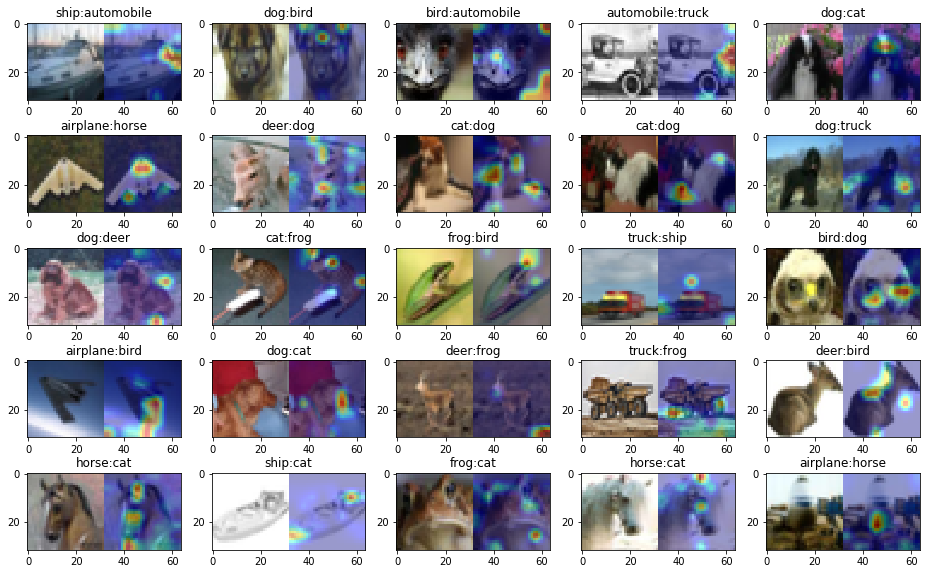

In [0]:
incorrect_idx_list = get_incorrect_im(X_test)
#print(len(incorrect_idx_list), incorrect_idx_list[:10])

print("For first incorrect image :")
print("Actual label ", label_dict.get(test_classes[incorrect_idx_list[0]]))
print("Predicted label ", label_dict.get(pred_classes[incorrect_idx_list[0]]))

img_list = incorrect_idx_list[:25]
print(img_list)
plot_gradCam(cutout_model, img_list)